In [1]:
%load_ext autoreload
%autoreload 2

from infomap import Infomap
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
!cd simulate && cargo build --release

    Finished release [optimized] target(s) in 0.00s


In [3]:
edges = [
    (1, 2), (2, 1),
    (1, 3), (3, 1),
    (2, 3), (3, 2),
    (3, 4), (4, 3),
    (4, 5), (5, 4),
    (4, 6), (6, 4),
    (5, 6), (6, 5),
]
    
G = nx.DiGraph(edges)
G.edges

OutEdgeView([(1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 4), (4, 3), (4, 5), (4, 6), (5, 4), (5, 6), (6, 4), (6, 5)])

In [4]:
nx.write_edgelist(G, "two-triangles.net", data=False)

In [29]:
nx.set_node_attributes(G, {
    1: -1.0,
    2: -1.0,
    3: 0.0,
    4: 0.0,
    5: 1.0,
    6: 1.0,
}, "meta")

G.nodes.data("meta")

NodeDataView({1: -1.0, 2: -1.0, 3: 0.0, 4: 0.0, 5: 1.0, 6: 1.0}, data='meta')

In [6]:
meta_filename = "two-triangles.meta"

with open(meta_filename, "w") as f:
    for node, meta in nx.get_node_attributes(G, "meta").items():
        f.write(f"{node} {meta}\n")

In [7]:
im = Infomap(two_level=True, num_trials=10)
im.add_networkx_graph(G)
im.run()
im.write_tree("two-triangles.tree")

'two-triangles.tree'

In [30]:
ss = np.linspace(1, 0.0001, endpoint=True, num=4)
ss

array([1.000e+00, 6.667e-01, 3.334e-01, 1.000e-04])

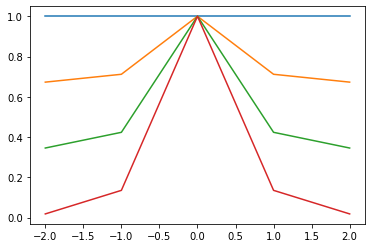

In [36]:
meta = [meta for _, meta in G.nodes.data("meta")]

meta_scale = 0.5
for meta_scale in (0.5,):
    for s in ss:
        x = sorted([xi - xj for xi in meta for xj in meta])
        y = [(1 - s) * np.exp(-abs(dist) / meta_scale) + s for dist in x]
        plt.plot(x, y)

In [10]:
import subprocess

n_samples = 10**6
meta_scale = 0.2
simulate = "simulate/target/release/simulate"

for i, s in enumerate(ss):
    out_name = f"out_{i}.temp"
    
    subprocess.run([simulate, "-r",
                    "two-triangles.net", "two-triangles.meta", out_name,
                    str(s), str(meta_scale), str(n_samples)],
                   check=True)
    
    im = Infomap(two_level=True, num_trials=10, flow_model="rawdir", silent=True)
    im.read_file(out_name)
    im.run()
    im.write_flow_tree(f"two-triangles_{i}.ftree")